In [1]:
%cd ..

E:\annotation_app


In [7]:
import sys
sys.path.append("E:/annotation_app/backends/SiamMask")
sys.path.append("E:/annotation_app/backends/SiamMask/experiments/siammask_sharp")

In [8]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import cv2

In [9]:
from argparse import Namespace

In [10]:
from image_array import MovieImageArray

In [11]:
from tools.test import load_config, load_pretrain, siamese_init, get_subwindow_tracking
from custom import Custom

### Siamemask Trackerの書き換え 

元のやつ

In [12]:
def siamese_track(state, im, mask_enable=False, refine_enable=False, device='cpu', debug=False):
    p = state['p']
    net = state['net']
    avg_chans = state['avg_chans']
    window = state['window']
    target_pos = state['target_pos']
    target_sz = state['target_sz']

    wc_x = target_sz[1] + p.context_amount * sum(target_sz)
    hc_x = target_sz[0] + p.context_amount * sum(target_sz)
    s_x = np.sqrt(wc_x * hc_x)
    scale_x = p.exemplar_size / s_x
    d_search = (p.instance_size - p.exemplar_size) / 2
    pad = d_search / scale_x
    s_x = s_x + 2 * pad
    crop_box = [target_pos[0] - round(s_x) / 2, target_pos[1] - round(s_x) / 2, round(s_x), round(s_x)]

    if debug:
        im_debug = im.copy()
        crop_box_int = np.int0(crop_box)
        cv2.rectangle(im_debug, (crop_box_int[0], crop_box_int[1]),
                      (crop_box_int[0] + crop_box_int[2], crop_box_int[1] + crop_box_int[3]), (255, 0, 0), 2)
        cv2.imshow('search area', im_debug)
        cv2.waitKey(0)

    # extract scaled crops for search region x at previous target position
    x_crop = Variable(get_subwindow_tracking(im, target_pos, p.instance_size, round(s_x), avg_chans).unsqueeze(0))

    if mask_enable:
        score, delta, mask = net.track_mask(x_crop.to(device))
    else:
        score, delta = net.track(x_crop.to(device))

    delta = delta.permute(1, 2, 3, 0).contiguous().view(4, -1).data.cpu().numpy()
    score = F.softmax(score.permute(1, 2, 3, 0).contiguous().view(2, -1).permute(1, 0), dim=1).data[:,
            1].cpu().numpy()

    delta[0, :] = delta[0, :] * p.anchor[:, 2] + p.anchor[:, 0]
    delta[1, :] = delta[1, :] * p.anchor[:, 3] + p.anchor[:, 1]
    delta[2, :] = np.exp(delta[2, :]) * p.anchor[:, 2]
    delta[3, :] = np.exp(delta[3, :]) * p.anchor[:, 3]

    def change(r):
        return np.maximum(r, 1. / r)

    def sz(w, h):
        pad = (w + h) * 0.5
        sz2 = (w + pad) * (h + pad)
        return np.sqrt(sz2)

    def sz_wh(wh):
        pad = (wh[0] + wh[1]) * 0.5
        sz2 = (wh[0] + pad) * (wh[1] + pad)
        return np.sqrt(sz2)

    # size penalty
    target_sz_in_crop = target_sz*scale_x
    s_c = change(sz(delta[2, :], delta[3, :]) / (sz_wh(target_sz_in_crop)))  # scale penalty
    r_c = change((target_sz_in_crop[0] / target_sz_in_crop[1]) / (delta[2, :] / delta[3, :]))  # ratio penalty

    penalty = np.exp(-(r_c * s_c - 1) * p.penalty_k)
    pscore = penalty * score

    # cos window (motion model)
    pscore = pscore * (1 - p.window_influence) + window * p.window_influence
    best_pscore_id = np.argmax(pscore)

    pred_in_crop = delta[:, best_pscore_id] / scale_x
    lr = penalty[best_pscore_id] * score[best_pscore_id] * p.lr  # lr for OTB

    res_x = pred_in_crop[0] + target_pos[0]
    res_y = pred_in_crop[1] + target_pos[1]

    res_w = target_sz[0] * (1 - lr) + pred_in_crop[2] * lr
    res_h = target_sz[1] * (1 - lr) + pred_in_crop[3] * lr

    target_pos = np.array([res_x, res_y])
    target_sz = np.array([res_w, res_h])

    # for Mask Branch
    if mask_enable:
        best_pscore_id_mask = np.unravel_index(best_pscore_id, (5, p.score_size, p.score_size))
        delta_x, delta_y = best_pscore_id_mask[2], best_pscore_id_mask[1]

        if refine_enable:
            mask = net.track_refine((delta_y, delta_x)).to(device).sigmoid().squeeze().view(
                p.out_size, p.out_size).cpu().data.numpy()
        else:
            mask = mask[0, :, delta_y, delta_x].sigmoid(). \
                squeeze().view(p.out_size, p.out_size).cpu().data.numpy()

        def crop_back(image, bbox, out_sz, padding=-1):
            a = (out_sz[0] - 1) / bbox[2]
            b = (out_sz[1] - 1) / bbox[3]
            c = -a * bbox[0]
            d = -b * bbox[1]
            mapping = np.array([[a, 0, c],
                                [0, b, d]]).astype(np.float)
            crop = cv2.warpAffine(image, mapping, (out_sz[0], out_sz[1]),
                                  flags=cv2.INTER_LINEAR,
                                  borderMode=cv2.BORDER_CONSTANT,
                                  borderValue=padding)
            return crop

        s = crop_box[2] / p.instance_size
        sub_box = [crop_box[0] + (delta_x - p.base_size / 2) * p.total_stride * s,
                   crop_box[1] + (delta_y - p.base_size / 2) * p.total_stride * s,
                   s * p.exemplar_size, s * p.exemplar_size]
        s = p.out_size / sub_box[2]
        back_box = [-sub_box[0] * s, -sub_box[1] * s, state['im_w'] * s, state['im_h'] * s]
        mask_in_img = crop_back(mask, back_box, (state['im_w'], state['im_h']))

        target_mask = (mask_in_img > p.seg_thr).astype(np.uint8)
        if cv2.__version__[-5] == '4':
            contours, _ = cv2.findContours(target_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        else:
            _, contours, _ = cv2.findContours(target_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt_area = [cv2.contourArea(cnt) for cnt in contours]
        if len(contours) != 0 and np.max(cnt_area) > 100:
            contour = contours[np.argmax(cnt_area)]  # use max area polygon
            polygon = contour.reshape(-1, 2)
            # pbox = cv2.boundingRect(polygon)  # Min Max Rectangle
            prbox = cv2.boxPoints(cv2.minAreaRect(polygon))  # Rotated Rectangle

            # box_in_img = pbox
            rbox_in_img = prbox
        else:  # empty mask
            location = cxy_wh_2_rect(target_pos, target_sz)
            rbox_in_img = np.array([[location[0], location[1]],
                                    [location[0] + location[2], location[1]],
                                    [location[0] + location[2], location[1] + location[3]],
                                    [location[0], location[1] + location[3]]])

    target_pos[0] = max(0, min(state['im_w'], target_pos[0]))
    target_pos[1] = max(0, min(state['im_h'], target_pos[1]))
    target_sz[0] = max(10, min(state['im_w'], target_sz[0]))
    target_sz[1] = max(10, min(state['im_h'], target_sz[1]))

    state['target_pos'] = target_pos
    state['target_sz'] = target_sz
    state['score'] = score[best_pscore_id]
    state['mask'] = mask_in_img if mask_enable else []
    state['ploygon'] = rbox_in_img if mask_enable else []
    return state

新しく定義する方

In [13]:
def siamese_track_v2(state, im, mask_enable=True, refine_enable=True, polygon_enable=True, device='cpu', debug=False):
    p = state['p']
    net = state['net']
    avg_chans = state['avg_chans']
    window = state['window']
    target_pos = state['target_pos']
    target_sz = state['target_sz']

    wc_x = target_sz[1] + p.context_amount * sum(target_sz)
    hc_x = target_sz[0] + p.context_amount * sum(target_sz)
    s_x = np.sqrt(wc_x * hc_x)
    scale_x = p.exemplar_size / s_x
    d_search = (p.instance_size - p.exemplar_size) / 2
    pad = d_search / scale_x
    s_x = s_x + 2 * pad
    crop_box = [target_pos[0] - round(s_x) / 2, target_pos[1] - round(s_x) / 2, round(s_x), round(s_x)]

    if debug:
        im_debug = im.copy()
        crop_box_int = np.int0(crop_box)
        cv2.rectangle(im_debug, (crop_box_int[0], crop_box_int[1]),
                      (crop_box_int[0] + crop_box_int[2], crop_box_int[1] + crop_box_int[3]), (255, 0, 0), 2)
        cv2.imshow('search area', im_debug)
        cv2.waitKey(0)

    # extract scaled crops for search region x at previous target position
    x_crop = Variable(get_subwindow_tracking(im, target_pos, p.instance_size, round(s_x), avg_chans).unsqueeze(0))

    if mask_enable:
        score, delta, mask = net.track_mask(x_crop.to(device))
    else:
        score, delta = net.track(x_crop.to(device))

    delta = delta.permute(1, 2, 3, 0).contiguous().view(4, -1).data.cpu().numpy()
    score = F.softmax(score.permute(1, 2, 3, 0).contiguous().view(2, -1).permute(1, 0), dim=1).data[:,
            1].cpu().numpy()

    delta[0, :] = delta[0, :] * p.anchor[:, 2] + p.anchor[:, 0]
    delta[1, :] = delta[1, :] * p.anchor[:, 3] + p.anchor[:, 1]
    delta[2, :] = np.exp(delta[2, :]) * p.anchor[:, 2]
    delta[3, :] = np.exp(delta[3, :]) * p.anchor[:, 3]

    def change(r):
        return np.maximum(r, 1. / r)

    def sz(w, h):
        pad = (w + h) * 0.5
        sz2 = (w + pad) * (h + pad)
        return np.sqrt(sz2)

    def sz_wh(wh):
        pad = (wh[0] + wh[1]) * 0.5
        sz2 = (wh[0] + pad) * (wh[1] + pad)
        return np.sqrt(sz2)

    # size penalty
    target_sz_in_crop = target_sz*scale_x
    s_c = change(sz(delta[2, :], delta[3, :]) / (sz_wh(target_sz_in_crop)))  # scale penalty
    r_c = change((target_sz_in_crop[0] / target_sz_in_crop[1]) / (delta[2, :] / delta[3, :]))  # ratio penalty

    penalty = np.exp(-(r_c * s_c - 1) * p.penalty_k)
    pscore = penalty * score

    # cos window (motion model)
    pscore = pscore * (1 - p.window_influence) + window * p.window_influence
    best_pscore_id = np.argmax(pscore)

    pred_in_crop = delta[:, best_pscore_id] / scale_x
    lr = penalty[best_pscore_id] * score[best_pscore_id] * p.lr  # lr for OTB

    res_x = pred_in_crop[0] + target_pos[0]
    res_y = pred_in_crop[1] + target_pos[1]

    res_w = target_sz[0] * (1 - lr) + pred_in_crop[2] * lr
    res_h = target_sz[1] * (1 - lr) + pred_in_crop[3] * lr

    target_pos = np.array([res_x, res_y])
    target_sz = np.array([res_w, res_h])

    # for Mask Branch
    if mask_enable:
        best_pscore_id_mask = np.unravel_index(best_pscore_id, (5, p.score_size, p.score_size))
        delta_x, delta_y = best_pscore_id_mask[2], best_pscore_id_mask[1]

        if refine_enable:
            mask = net.track_refine((delta_y, delta_x)).to(device).sigmoid().squeeze().view(
                p.out_size, p.out_size).cpu().data.numpy()
        else:
            mask = mask[0, :, delta_y, delta_x].sigmoid(). \
                squeeze().view(p.out_size, p.out_size).cpu().data.numpy()

        def crop_back(image, bbox, out_sz, padding=-1):
            a = (out_sz[0] - 1) / bbox[2]
            b = (out_sz[1] - 1) / bbox[3]
            c = -a * bbox[0]
            d = -b * bbox[1]
            mapping = np.array([[a, 0, c],
                                [0, b, d]]).astype(np.float)
            crop = cv2.warpAffine(image, mapping, (out_sz[0], out_sz[1]),
                                  flags=cv2.INTER_LINEAR,
                                  borderMode=cv2.BORDER_CONSTANT,
                                  borderValue=padding)
            return crop

        s = crop_box[2] / p.instance_size
        sub_box = [crop_box[0] + (delta_x - p.base_size / 2) * p.total_stride * s,
                   crop_box[1] + (delta_y - p.base_size / 2) * p.total_stride * s,
                   s * p.exemplar_size, s * p.exemplar_size]
        s = p.out_size / sub_box[2]
        back_box = [-sub_box[0] * s, -sub_box[1] * s, state['im_w'] * s, state['im_h'] * s]
        mask_in_img = crop_back(mask, back_box, (state['im_w'], state['im_h']))

        target_mask = (mask_in_img > p.seg_thr).astype(np.uint8)
        if cv2.__version__[-5] == '4':
            contours, _ = cv2.findContours(target_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        else:
            _, contours, _ = cv2.findContours(target_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt_area = [cv2.contourArea(cnt) for cnt in contours]
        if len(contours) != 0 and np.max(cnt_area) > 100:
            contour = contours[np.argmax(cnt_area)]  # use max area polygon
            polygon = contour.reshape(-1, 2)
            pbox = cv2.boundingRect(polygon)  # Min Max Rectangle
            #prbox = cv2.boxPoints(cv2.minAreaRect(polygon))  # Rotated Rectangle

            box_in_img = pbox
            #rbox_in_img = prbox

            if polygon_enable:
                epsilon = 0.01*cv2.arcLength(polygon, True)
                approx = cv2.approxPolyDP(polygon, epsilon, True)
            else:
                approx = None

            can_get_mask = True
        else:  # empty mask
            box_in_img = None
            approx = None
            can_get_mask = False
    else:
        mask_in_img = None
        box_in_img = None
        approx = None
        can_get_mask = False

    target_pos[0] = max(0, min(state['im_w'], target_pos[0]))
    target_pos[1] = max(0, min(state['im_h'], target_pos[1]))
    target_sz[0] = max(10, min(state['im_w'], target_sz[0]))
    target_sz[1] = max(10, min(state['im_h'], target_sz[1]))

    state['target_pos'] = target_pos
    state['target_sz'] = target_sz
    state['score'] = score[best_pscore_id]
    state['mask'] = mask_in_img
    state['bbox'] = box_in_img
    state["polygon"] = approx
    return state

### siammaskのコンストラクト 

In [14]:
configarg = Namespace(resume="E:/annotation_app/backends/SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth",
                      config="E:/annotation_app/backends/SiamMask/experiments/siammask_sharp/config_davis.json",
                      base_path="",
                      cpu=True,
                     )


In [15]:
cfg = load_config(configarg)
siammask = Custom(anchors=cfg['anchors'])

[2021-04-22 19:00:34,577-rk0-features.py# 66] Current training 0 layers:
	
[2021-04-22 19:00:34,600-rk0-features.py# 66] Current training 1 layers:
	


In [16]:
siammask = load_pretrain(siammask, configarg.resume)

[2021-04-22 19:00:38,492-rk0-load_helper.py# 31] load pretrained model from E:/annotation_app/backends/SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth
[2021-04-22 19:00:41,106-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-04-22 19:00:41,169-rk0-load_helper.py# 18] used keys:356


In [17]:
device = torch.device("cpu")
siammask.eval().to(device)

Custom(
  (upSample): UpsamplingBilinear2d(size=[127, 127], mode=bilinear)
  (features): ResDown(
    (features): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

### 動画の読み込み 

In [18]:
Path("sample_movie/sample_movie_1.mp4").exists()

True

In [19]:
movie_path = Path("sample_movie/sample_movie_1.mp4")
temp_path = Path("temp")
image_array = MovieImageArray(movie_path, is_temp=False, temp_dir=temp_path)

In [20]:
image_array.read_movie(is_update=False)

### 最初の矩形 

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

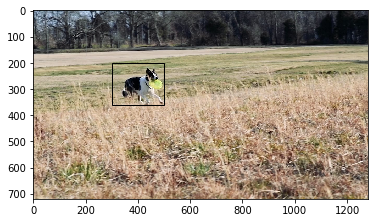

In [24]:
fig, ax = plt.subplots()

x1 = 300
y1 = 200
x2 = 500
y2 = 360

w = x2 - x1
h = y2 - y1

ax.imshow(image_array[0][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)

In [25]:
target_pos = np.array([x1 + w/2, y1+h/2])
target_sz = np.array([w, h])
first_image = image_array[0]
first_state = siamese_init(first_image, 
                           target_pos,
                           target_sz,
                           siammask,
                           cfg['hp'],
                           device=device)

### 次の矩形を予測 

In [26]:
second_image = image_array[1]
second_state = siamese_track_v2(first_state,
                      second_image,
                      mask_enable=True,
                      refine_enable=True,
                      device=device
                     )

c:\users\asami naoto\anaconda3\envs\annotation_py36\lib\site-packages\torch\nn\functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
%%timeit 
second_image = image_array[1]
second_state = siamese_track_v2(first_state,
                      second_image,
                      mask_enable=True,
                      refine_enable=True,
                      polygon_enable=False,
                      device=device
                     )

In [28]:
second_state

{'im_h': 720,
 'im_w': 1280,
 'p': <utils.tracker_config.TrackerConfig at 0x1fc6fff5eb8>,
 'net': Custom(
   (upSample): UpsamplingBilinear2d(size=[127, 127], mode=bilinear)
   (features): ResDown(
     (features): ResNet(
       (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (layer1): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv3): Conv2d(64, 256, kernel_size=

In [29]:
mask = second_state['mask'] > second_state['p'].seg_thr
x,y,w,h = second_state["bbox"]

second_image[:, :, 2] = (mask > 0) * 255 + (mask == 0) * second_image[:, :, 2]
polygon_array = second_state["polygon"].squeeze()

In [30]:
polygon_array

array([[461, 226],
       [435, 221],
       [426, 254],
       [380, 257],
       [349, 274],
       [335, 325],
       [350, 354],
       [382, 344],
       [427, 367],
       [466, 336],
       [485, 360],
       [498, 362],
       [496, 346],
       [473, 322],
       [473, 307],
       [492, 300],
       [495, 286]], dtype=int32)

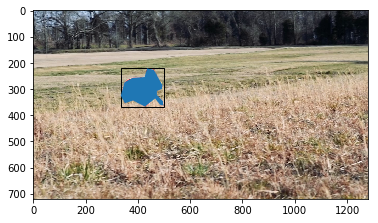

In [31]:
fig, ax = plt.subplots()

ax.imshow(second_image[:,:,::-1])
rectangle = patches.Rectangle((x, y),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(polygon_array, closed=True)
ax.add_patch(polygon)

### 以上を利用したTrackerクラス 

In [37]:
class SiameseMaskTracker:
    def __init__(self, device=torch.device("cpu")):
        configarg = Namespace(resume="backends/SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth",
                              config="backends/SiamMask/experiments/siammask_sharp/config_davis.json",
                              base_path="",
                              cpu=True,
                             )
        self.cfg = load_config(configarg)
        siammask = Custom(anchors=self.cfg['anchors'])
        
        self.siammask = load_pretrain(siammask, configarg.resume)
        self.siammask.eval().to(device)
        self.device = device
        
    def set_bbox(self, image, xyxy_dict=None, polygon_list=None):
        if xyxy_dict is None:
            raise Exception("SiameseMaskTracker set_bbox need xyxy_dict")
        x1 = xyxy_dict["x1"]
        y1 = xyxy_dict["y1"]
        x2 = xyxy_dict["x2"]
        y2 = xyxy_dict["y2"]
        
        w = x2 - x1
        h = y2 - y1
        
        target_pos = np.array([x1 + w/2, y1+h/2])
        target_sz = np.array([w, h])
        self.state = siamese_init(image, 
                                  target_pos,
                                  target_sz,
                                  self.siammask,
                                  self.cfg['hp'],
                                  device=self.device)
        
    def get_bbox(self, image):
        self.state = siamese_track_v2(self.state,
                                      image,
                                      mask_enable=True,
                                      refine_enable=True,
                                      polygon_enable=True,
                                      device=self.device
                                     )
        
        out_dict = {}
        xywh = self.state["bbox"]
        xyxy_dict = {"x1":int(xywh[0]), "y1":int(xywh[1]), "x2":int(xywh[0]+xywh[2]), "y2":int(xywh[1]+xywh[3])}
        out_dict["bbox_dict"] = xyxy_dict
        

        polygon_array = self.state["polygon"].squeeze()
        polygon_list = []
        for one_point_list in polygon_array:
            polygon_list.append({"x":int(one_point_list[0]),"y":int(one_point_list[1])})
        out_dict["polygon"] = polygon_list
        
        return out_dict

In [38]:
box_tracker = SiameseMaskTracker()

[2021-04-22 19:14:45,170-rk0-features.py# 66] Current training 0 layers:
	
[2021-04-22 19:14:45,185-rk0-features.py# 66] Current training 1 layers:
	
[2021-04-22 19:14:45,566-rk0-load_helper.py# 31] load pretrained model from backends/SiamMask/experiments/siammask_sharp/SiamMask_DAVIS.pth
[2021-04-22 19:14:45,866-rk0-load_helper.py# 25] remove prefix 'module.'
[2021-04-22 19:14:45,893-rk0-load_helper.py# 18] used keys:356


In [39]:
x1 = 300
y1 = 200
x2 = 500
y2 = 360
xyxy_dict = {"x1":x1, "y1":y1, "x2":x2, "y2":y2}

In [40]:
box_tracker.set_bbox(image_array[0], xyxy_dict)

In [41]:
out_dict = box_tracker.get_bbox(image_array[1])

In [42]:
out_dict

{'bbox_dict': {'x1': 335, 'y1': 220, 'x2': 500, 'y2': 368},
 'polygon': [{'x': 461, 'y': 226},
  {'x': 435, 'y': 221},
  {'x': 426, 'y': 254},
  {'x': 380, 'y': 257},
  {'x': 349, 'y': 274},
  {'x': 335, 'y': 325},
  {'x': 350, 'y': 354},
  {'x': 382, 'y': 344},
  {'x': 427, 'y': 367},
  {'x': 466, 'y': 336},
  {'x': 485, 'y': 360},
  {'x': 498, 'y': 362},
  {'x': 496, 'y': 346},
  {'x': 473, 'y': 322},
  {'x': 473, 'y': 307},
  {'x': 492, 'y': 300},
  {'x': 495, 'y': 286}]}

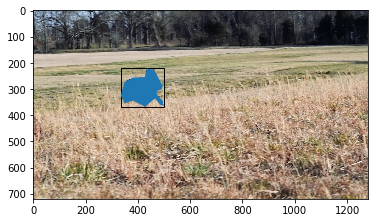

In [43]:
fig, ax = plt.subplots()

pos_dict = out_dict["bbox_dict"]
x1,y1,x2,y2 = pos_dict["x1"], pos_dict["y1"], pos_dict["x2"], pos_dict["y2"]

w = x2 - x1
h = y2 - y1

polygon_array = [[one_point["x"], one_point["y"]] for one_point in out_dict["polygon"]]

ax.imshow(image_array[1][:,:,::-1])
rectangle = patches.Rectangle((x1, y1),w,h, fill=False)
ax.add_patch(rectangle)
polygon = patches.Polygon(polygon_array, closed=True)
ax.add_patch(polygon)